<a href="https://colab.research.google.com/github/singhals163/SURGE-22/blob/master/Bright_Dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib
from google.colab.patches import cv2_imshow
from cv2.ximgproc import guidedFilter

In [ ]:
def read_image(image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  cv2_imshow(image)
  return image

In [ ]:
def channels(image, box_size):
  box = int(box_size/2)
  (H,W,_) = np.shape(image)
  image_1 = cv2.copyMakeBorder(image, box, box, box, box, cv2.BORDER_REFLECT)
  dark = np.zeros((image.shape[0],image.shape[1]))
  bright = np.zeros((image.shape[0],image.shape[1]))
  for i in range(H):
    for j in range(W):
      dark[i][j] = np.amin(image_1[i:box_size+i, j:box_size+j, :])
      bright[i][j] = np.amax(image_1[i:box_size+i, j:box_size+j, :])
  return dark, bright 

In [ ]:
def largest_10(image):
  (H,W) = np.shape(image)
  idxs = np.argsort(image.ravel())[-(np.size(image)//10):]
  rows, cols = idxs//np.shape(image)[1], idxs%np.shape(image)[1]
  index = []
  for i in range(np.size(rows)):
    index.append([rows[i],cols[i]])
  return index

In [ ]:
def atmospheric_light_estimation(image, index):
  atmospheric_light = [0,0,0]
  for i in range(len(index)):
    atmospheric_light[0] += image[index[i][0]][index[i][1]][0]
    atmospheric_light[1] += image[index[i][0]][index[i][1]][1]
    atmospheric_light[2] += image[index[i][0]][index[i][1]][2]
  atmospheric_light[0] = atmospheric_light[0]/len(index)
  atmospheric_light[1] = atmospheric_light[1]/len(index)
  atmospheric_light[2] = atmospheric_light[2]/len(index)
  return atmospheric_light

In [ ]:
def transmission_estimation(image, atmos):
  A = np.amax(atmos)
  trans = (image-A)/(1.0-A)
  return (trans - np.amin(trans))/(np.amax(trans) - np.amin(trans))

In [ ]:
def correcteed_transmission_map(image, bright, dark, thresh, atmos, omega, bright_trans, boxsize):
  difference = bright-dark
  im = np.zeros(np.shape(image))
  for k in range(3):
    im[:,:,k] = image[:,:,k]/atmos[k]
  dark_trans, _ = channels(im, boxsize)
  dark_trans = (dark_trans - np.min(dark_trans))/(np.max(dark_trans) - np.min(dark_trans))
  dark_trans = 1 - omega*dark_trans
  (H, W,) = np.shape(dark_trans)
  # print(H,W)
  
  corrected_t = bright_trans
  # print(np.shape(dark_thresh_mask))
  for i in range(H):
    for j in range(W):
      if difference[i][j]<=thresh:
        corrected_t[i][j] = dark_trans[i][j]*bright_trans[i][j]
  return corrected_t

In [ ]:
def radiance(image, smooth_trans, atmos, t0):
    rad = np.zeros(np.shape(image))
    H, W, _ = np.shape(image)
    for i in range(H):
      for j in range(W):
        for k in range(3):
          rad[i,j,k] = (image[i, j, k] - atmos[k])/(max(smooth_trans[i,j], t0)) +atmos[k]
    
    # return (rad - np.min(rad))/(np.max(rad) - np.min(rad))
    return rad

In [ ]:
def enhanced_transmission_map(bright):
  xp = [0,120,255]
  fp = [0,120,140]
  x = np.arange(256)
  x = np.interp(x, xp, fp)
  bright = np.uint8(bright*255)
  bright = cv2.LUT(bright, x)
  bright = np.float64(bright)/255.0
  return bright

In [ ]:
def gamma_correction(bright):
  return np.power(bright, 0.8)

In [ ]:
def bright_prior(path, boxsize):

  # Generate the bright and dark channels
  image = read_image(path)
  image = image/255.0
  (dark, bright) = channels(image, boxsize)
  # cv2_imshow(dark*255)
  # cv2_imshow(bright*255)

  # find the atmospheric light
  atmos_index_bright = largest_10(bright)
  atmos_bright = atmospheric_light_estimation(image,atmos_index_bright)

  # Generate the transmission map from bright channel
  bright_trans = transmission_estimation(bright, atmos_bright)
  # cv2_imshow(bright_trans*255)

  # Generate the corrected transmission map from dark channel
  corrected_t = correcteed_transmission_map(image, bright, dark, 0.4, atmos_bright, 0.75, bright_trans, boxsize)
  # corrected_t = enhanced_transmission_map(corrected_t)


  # cv2_imshow(corrected_t*255)
  # cv2_imshow((bright_trans-corrected_t)*255)
  # print(corrected_trans.depth())
  # print(np.shape(image))
  # corrected_trans = corrected_t
  # corrected_trans = np.uint8(corrected_t*255)
  # cv2_imshow(corrected_trans)
  
  # Smoothen the transmission map by applying guided filter
  smoothened_map = guidedFilter(np.uint8(image*255), np.uint8(corrected_t*255), 15, (1e-2)*255*255)
  # cv2_imshow(smoothened_map)

  # Generate the final radiance image
  # cv2_imshow(image*255)
  # print(np.shape(image))
  rad = radiance(image, smoothened_map/255, atmos_bright, 0.1)
  # rad*=255
  # print(np.shape(rad))
  # rad = cv2.cvtColor(rad, cv2.COLOR_RGB2BGR)
  # print(rad[132:137, 237:242, 0])
  rad[:,:,0] = (rad[:,:,0] - np.min(rad[:,:,0]))/(np.max(rad[:,:,0]) - np.min(rad[:,:,0]))
  rad[:,:,1] = (rad[:,:,1] - np.min(rad[:,:,1]))/(np.max(rad[:,:,1]) - np.min(rad[:,:,1]))
  rad[:,:,2] = (rad[:,:,2] - np.min(rad[:,:,2]))/(np.max(rad[:,:,2]) - np.min(rad[:,:,2]))
  # rad = (rad - np.min(rad))/(np.max(rad) - np.min(rad))
  # print(rad[132:137, 237:242, 0])
  cv2_imshow(np.uint8(rad*255))
  # cv2_imshow((rad-image)*255)

In [ ]:
def enhanced_bright_prior(path, boxsize):
  # Generate the bright and dark channels
  image = read_image(path)
  image = image/255.0
  (dark, bright) = channels(image, boxsize)

  # find the atmospheric light
  atmos_index_bright = largest_10(bright)
  atmos_bright = atmospheric_light_estimation(image,atmos_index_bright)

  # Generate the transmission map from bright channel
  bright_trans = transmission_estimation(bright, atmos_bright)
  # bright_trans = gamma_correction(bright_trans)
  # bright_trans = enhanced_transmission_map(bright_trans)

  # Generate the corrected transmission map from dark channel
  corrected_t = correcteed_transmission_map(image, bright, dark, 0.4, atmos_bright, 0.75, bright_trans, boxsize)
  # corrected_t = enhanced_transmission_map(corrected_t)

  # Smoothen the transmission map by applying guided filter
  smoothened_map = guidedFilter(np.uint8(image*255), np.uint8(corrected_t*255), 15, (1e-2)*255*255)

  # Generate the final radiance image
  rad = radiance(image, smoothened_map/255, atmos_bright, 0.1)
  rad[:,:,0] = (rad[:,:,0] - np.min(rad[:,:,0]))/(np.max(rad[:,:,0]) - np.min(rad[:,:,0]))
  rad[:,:,1] = (rad[:,:,1] - np.min(rad[:,:,1]))/(np.max(rad[:,:,1]) - np.min(rad[:,:,1]))
  rad[:,:,2] = (rad[:,:,2] - np.min(rad[:,:,2]))/(np.max(rad[:,:,2]) - np.min(rad[:,:,2]))
  rad = gamma_correction(rad)
  cv2_imshow(np.uint8(rad*255))

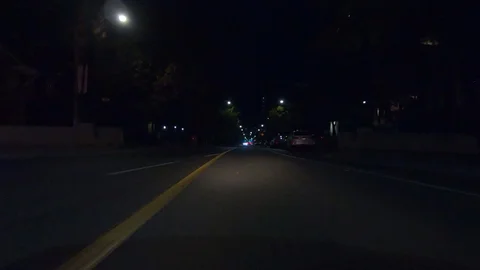

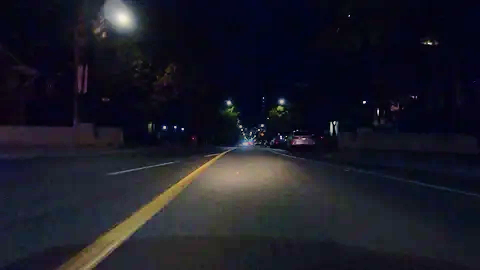

In [ ]:
# bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp", 9)
enhanced_bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp", 3)

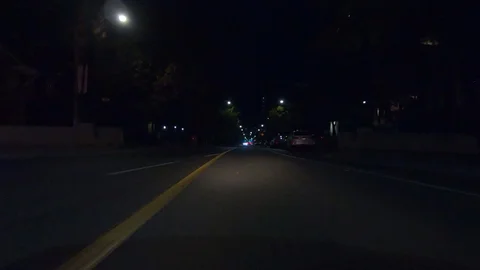

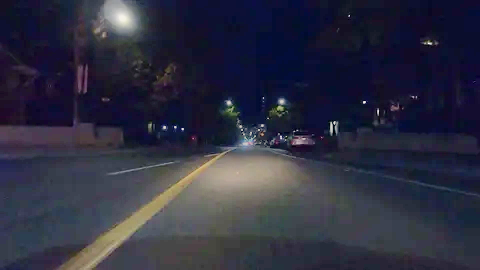

In [ ]:
# bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp", 7)
enhanced_bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp", 3)

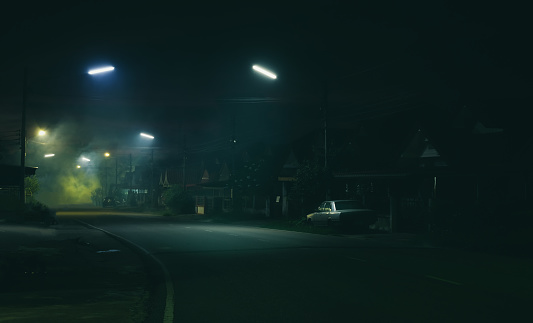

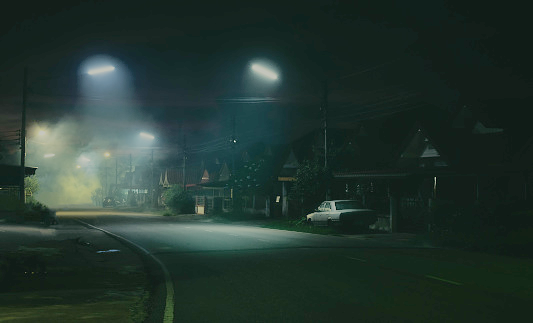

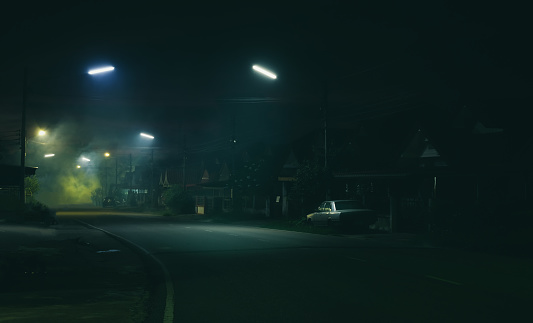

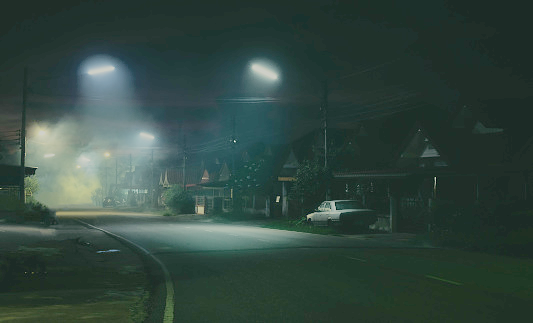

In [ ]:
bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/istockphoto-1151075791-170667a.jpg", 3)
enhanced_bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/istockphoto-1151075791-170667a.jpg", 3)

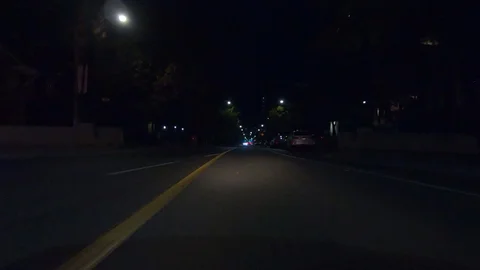

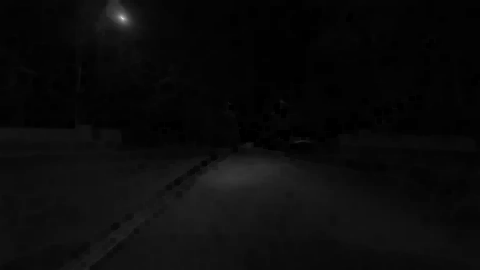

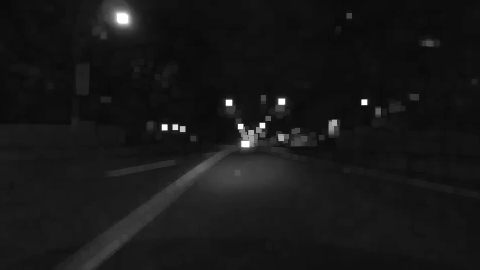

In [ ]:
image = read_image("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp")
image = image/255.0
(dark, bright) = channels(image, 5)
cv2_imshow(dark*255)
cv2_imshow(bright*255)

In [ ]:
atmos_index_bright = largest_10(bright)
atmos_bright = atmospheric_light_estimation(image,atmos_index_bright)
print(atmos_bright)

[0.14006445170661044, 0.1501425199709541, 0.15631747760833148]


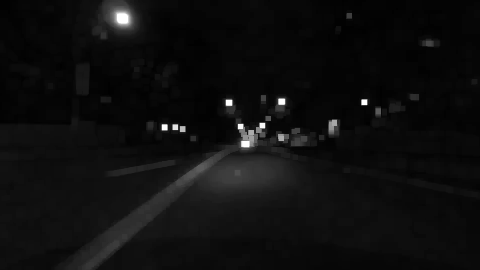

In [ ]:
bright_trans = transmission_estimation(bright, atmos_bright)
cv2_imshow(bright_trans*255)

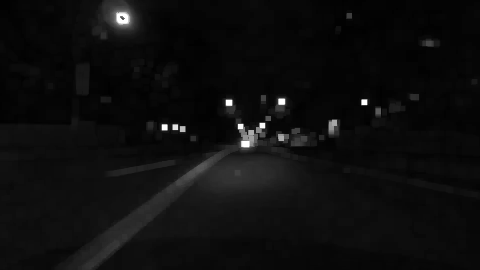

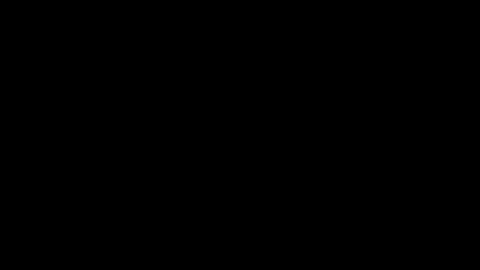

In [ ]:
corrected_t = correcteed_transmission_map(image, bright, dark, 0.4, atmos_bright, 0.75, bright_trans)
cv2_imshow(corrected_t*255)
cv2_imshow((bright_trans-corrected_t)*255)

(270, 480, 3)


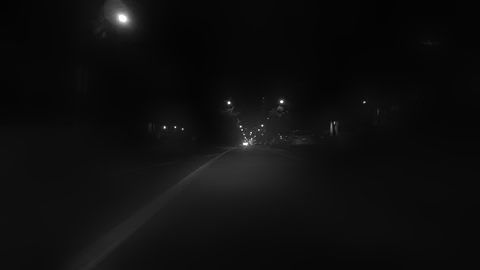

In [ ]:
# print(corrected_trans.depth())
print(np.shape(image))
corrected_trans = corrected_t
# corrected_trans = np.uint8(corrected_t*255)
# cv2_imshow(corrected_trans)
smoothened_map = guidedFilter(np.uint8(image*255), np.uint8(corrected_t*255), 15, (1e-2)*225*225)
cv2_imshow(smoothened_map)

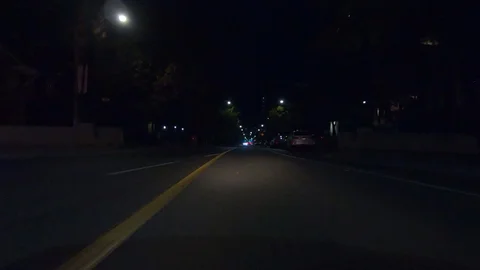

(270, 480, 3)
(270, 480, 3)
[[-0.26292107 -0.24326324 -0.23413639 -0.10402795 -0.31643397]
 [-0.26292107 -0.24326324 -0.23413639 -0.16474522 -0.0275593 ]
 [-0.26292107 -0.24326324 -0.20217823 -0.16474522 -0.17985805]
 [-0.26292107 -0.24326324 -0.1092214  -0.09904647 -0.17305119]
 [-0.29984174 -0.21032686 -0.19439998 -0.11945463 -0.11426425]]
[[0.34937037 0.35625434 0.35945048 0.40501317 0.33063067]
 [0.34937037 0.35625434 0.35945048 0.38375058 0.43179174]
 [0.34937037 0.35625434 0.37064191 0.38375058 0.37845822]
 [0.34937037 0.35625434 0.40319448 0.40675764 0.38084191]
 [0.33644111 0.36778834 0.37336577 0.3996109  0.40142852]]


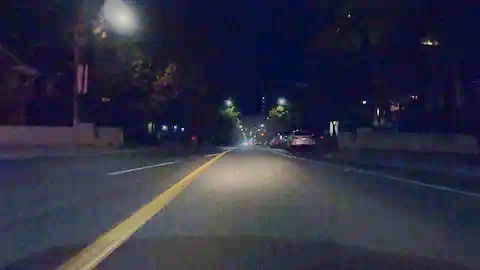

In [ ]:
cv2_imshow(image*255)
print(np.shape(image))
rad = radiance(image, smoothened_map/255, atmos_bright,0.1)
# rad*=255
print(np.shape(rad))
# rad = cv2.cvtColor(rad, cv2.COLOR_RGB2BGR)
print(rad[132:137, 237:242, 0])
rad[:,:,0] = (rad[:,:,0] - np.min(rad[:,:,0]))/(np.max(rad[:,:,0]) - np.min(rad[:,:,0]))
rad[:,:,1] = (rad[:,:,1] - np.min(rad[:,:,1]))/(np.max(rad[:,:,1]) - np.min(rad[:,:,1]))
rad[:,:,2] = (rad[:,:,2] - np.min(rad[:,:,2]))/(np.max(rad[:,:,2]) - np.min(rad[:,:,2]))
# rad = (rad - np.min(rad))/(np.max(rad) - np.min(rad))
print(rad[132:137, 237:242, 0])
cv2_imshow(np.uint8(rad*255))

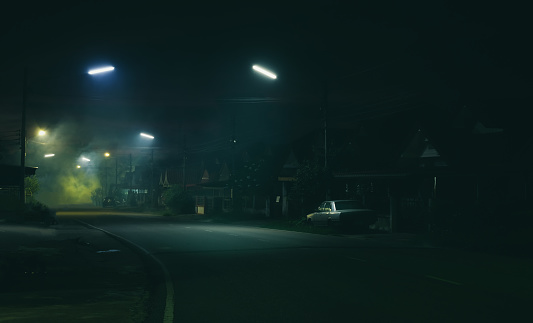

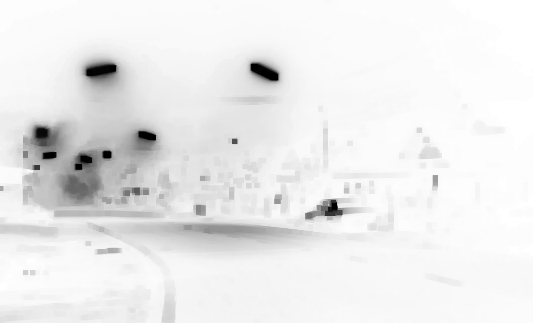

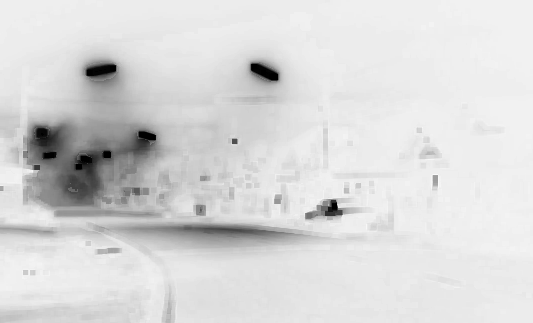

(323, 533)


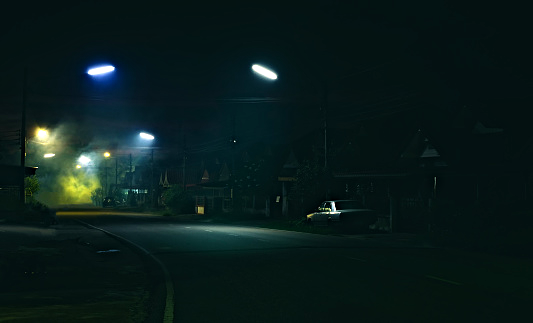

In [ ]:
image = read_image("/content/drive/MyDrive/SURGE/Color_Constancy/istockphoto-1151075791-170667a.jpg")
(dark, bright) = channels(image, 5)
atmos_index_bright = largest_10(bright)
atmos_bright = atmospheric_light_estimation(image,atmos_index_bright)

bright_trans = transmission_estimation(bright, atmos_bright)
cv2_imshow(bright_trans*255)
# atmos_index_dark = smallest_10(dark)
# atmos_dark = atmospheric_light_estimation(image, atmos_index_dark)

# dark_trans = transmission_estimation_dark(dark, atmos_dark)

# dark_trans_mask = difference_threshold_mask(bright, dark, 20, dark_trans)
# cv2_imshow(dark_trans_mask*255)
# corrected_trans = np.multiply(bright_trans, dark_trans_mask)
# cv2_imshow(corrected_trans*255)
# cv2_imshow((corrected_trans-bright_trans)*255)

corrected_t = correcteed_transmission_map(image, bright, dark, 0.4*255, atmos_bright, 0.95, bright_trans)
cv2_imshow(corrected_t*255)
corrected_t = np.uint8(corrected_t*255)
print(np.shape(corrected_t))
smoothened_map = smoothened_transmission_map(image, corrected_t, 5, (1e-2)*255*255)
# cv2_imshow(smoothened_map)

rad = radiance(image, smoothened_map/255, atmos_bright,0.5)
cv2_imshow(rad)

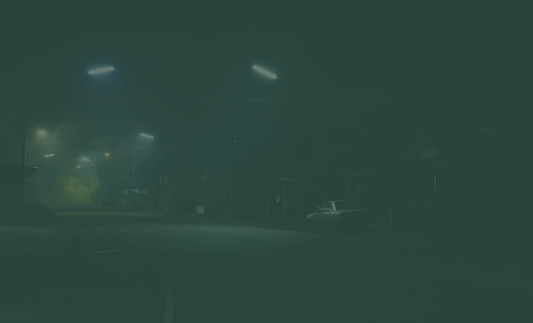

In [ ]:

rad = radiance(image, smoothened_map/255, atmos_bright,4)
cv2_imshow(rad)

[73, 82, 55]


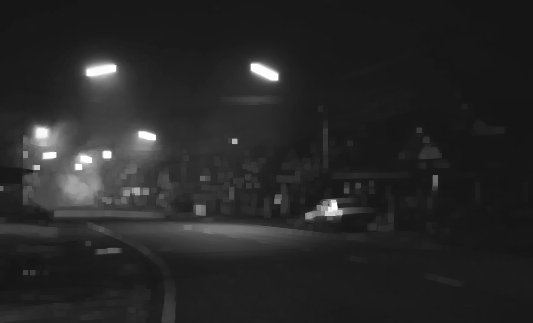

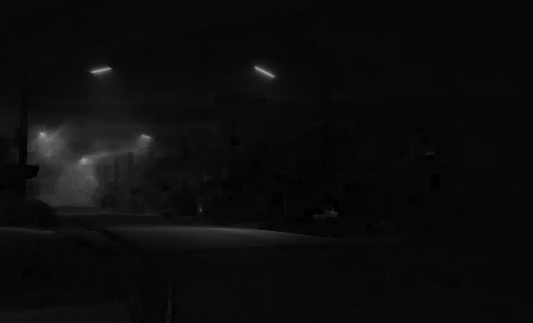

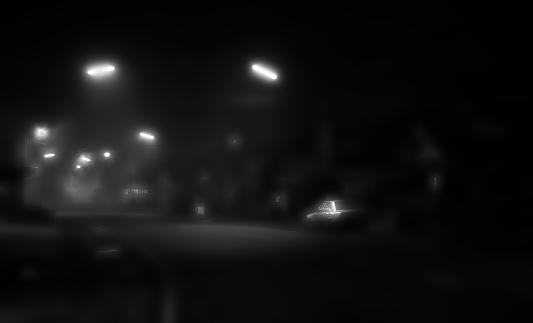

In [ ]:
print(atmos_bright)
cv2_imshow(bright)
cv2_imshow(dark)
cv2_imshow(smoothened_map)

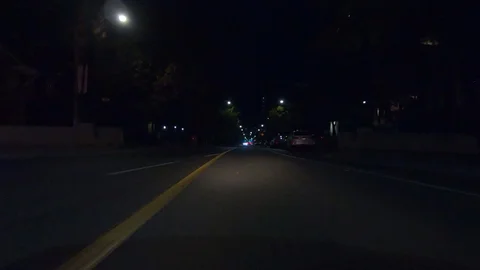

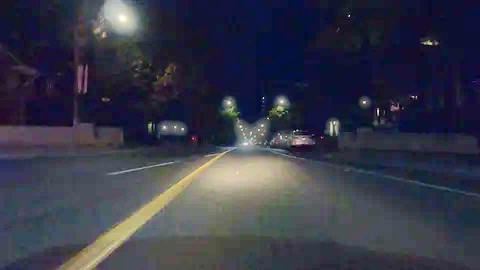

In [ ]:
bright_prior("/content/drive/MyDrive/SURGE/Color_Constancy/1.webp", 5)

In [ ]:
# import library
import numpy as np

# create numpy 1d-array
arr = np.array([2, 0, 1, 5,
				4, 1, 9, 8])
arr = arr.reshape((2,4))

print("Given array:", arr)

# sort an array in
# ascending order

# np.argsort() return
# array of indices for
# sorted array
idxs = np.argsort(arr.ravel())[-4:]
rows, cols = idxs//np.shape(arr)[1], idxs%np.shape(arr)[1]
print([rows,cols])
# sorted_index_array = np.argsort(arr)
# print(sorted_index_array)
# sorted array
# sorted_array = arr[sorted_index_array]

# print("Sorted array:", sorted_array)

# we want 1 largest value
# n = 1

# we are using negative
# indexing concept

# take n largest value
# rslt = sorted_array[-n : ]

# show the output
# print("{} largest value:".format(n),
# 	rslt[0])


Given array: [[2 0 1 5]
 [4 1 9 8]]
[array([1, 0, 1, 1]), array([0, 3, 3, 2])]


In [ ]:
def smoothened_transmission_map(image, p, rad, eps):
  smoothened_map = guidedFilter(image, p, rad, eps)
  return smoothened_map

In [ ]:
def smallest_10(image):
  (H,W) = np.shape(image)
  idxs = np.argsort(image.ravel())[(np.size(image)//10):]
  rows, cols = idxs//np.shape(image)[1], idxs%np.shape(image)[1]
  index = []
  for i in range(np.size(rows)):
    index.append([rows[i],cols[i]])
  return index

In [ ]:
idxs = np.argsort(bigrams.ravel())[-10:]
rows, cols = idxs//851, idxs%851
print(bigrams[rows,cols])

In [ ]:
def atmospheric_light(image,index):
  atmos = 0
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  for i in range(len(index)):
    atmos += gray_image[index[i][0]][index[i][1]]
  return atmos/len(index)